In [133]:
import pandas as pd
stock_data = pd.read_csv('./NFLX.csv',index_col='Date')
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-03-04,359.720001,362.250000,348.040009,351.040009,351.040009,7487000
2019-03-05,351.459991,356.170013,348.250000,354.299988,354.299988,5937800
2019-03-06,353.600006,359.880005,351.700012,359.609985,359.609985,6211900
2019-03-07,360.160004,362.859985,350.500000,352.600006,352.600006,6151300
2019-03-08,345.750000,349.920013,342.470001,349.600006,349.600006,6898800


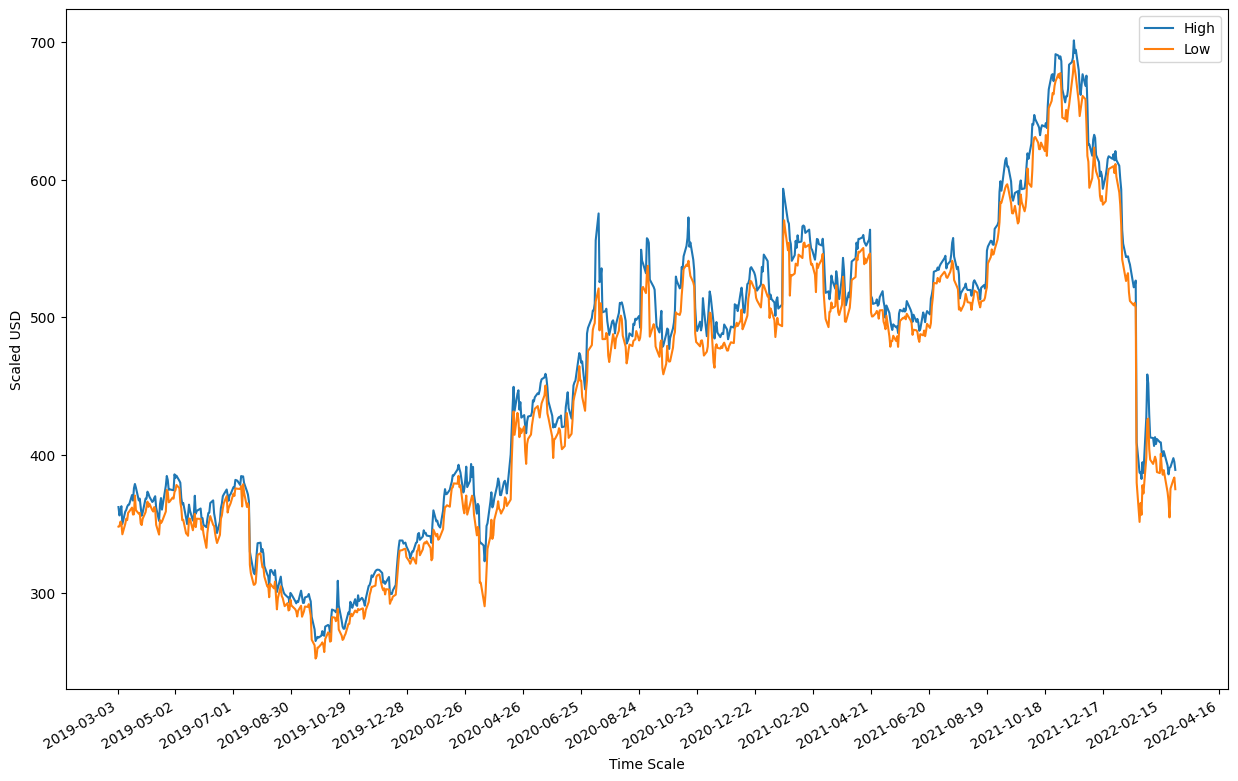

In [134]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import datetime as dt

plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))
x_dates = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in stock_data.index.values]

plt.plot(x_dates, stock_data['High'], label='High')
plt.plot(x_dates, stock_data['Low'], label='Low')

plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

In [135]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [188]:
target_Y = stock_data['Close']
X_feat = stock_data[['Open', 'High', 'Low']]


Epoch 1/100
19/19 [==============================] - 13s 102ms/step - loss: 0.2861 - val_loss: 0.7089
Epoch 2/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1508 - val_loss: 0.1933
Epoch 3/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0290 - val_loss: 0.0122
Epoch 4/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0195 - val_loss: 0.0208
Epoch 5/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0142 - val_loss: 0.0052
Epoch 6/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0102 - val_loss: 7.7877e-04
Epoch 7/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0080 - val_loss: 0.0011
Epoch 8/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0080 - val_loss: 0.0022
Epoch 9/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0071 - val_loss: 0.0057
Epoch 10/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0071 - val_loss: 0.0069
Ep

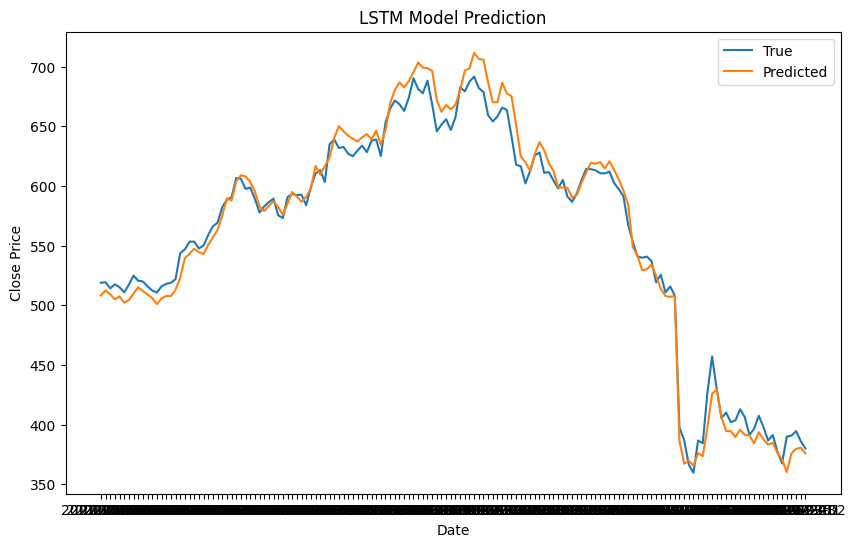

In [277]:
# Splitting the data into training and testing sets
split_index = int(len(stock_data) * 0.8)  # 80-20 train-test split
train_data = stock_data.iloc[:split_index]
test_data = stock_data.iloc[split_index:]


#Scaling the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[['Open', 'High', 'Low', 'Close']])
test_scaled = scaler.transform(test_data[['Open', 'High', 'Low', 'Close']])



X_train = train_scaled[:, :3]  # Features: 'Open', 'High', 'Low'
Y_train = train_scaled[:, 3]   # Target: 'Close'

X_test = test_scaled[:, :3]
Y_test = test_scaled[:, 3]



# Reshaping for LSTM input
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Define the LSTM model
lstm = Sequential()
lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm.add(Dropout(0.2))
lstm.add(LSTM(units=50, return_sequences=True))
lstm.add(Dropout(0.2))
lstm.add(LSTM(units=50))
lstm.add(Dropout(0.2))
lstm.add(Dense(units=1))

# Compile the model
lstm.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping callback
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# Fit the model
history = lstm.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(X_test, Y_test), callbacks=[es])

# Evaluate the model
predicted_values = lstm.predict(X_test)
#predicted_values = scaler.inverse_transform(predicted_values)  # Inverse scaling to get actual values
predicted_values = scaler.inverse_transform(np.concatenate((X_test.squeeze(), predicted_values), axis=1))[:, -1]  # Inverse scaling


# Calculate metrics (e.g., Mean Absolute Percentage Error)
predicted_values = lstm.predict(X_test)

#predicted_values = scaler.inverse_transform(predicted_values)  # Inverse scaling to get actual values
predicted_values = scaler.inverse_transform(np.concatenate((X_test.squeeze(), predicted_values), axis=1))[:, -1]  # Inverse scaling

mse = mean_squared_error(Y_test, predicted_values)
mape = mean_absolute_percentage_error(Y_test, predicted_values)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data['Close'], label='True')
plt.plot(test_data.index, predicted_values, label='Predicted')
plt.title('LSTM Model Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [247]:
Y_pred = model.predict(X_test)
rmse = mean_squared_error(Y_test, Y_pred, squared=False)

def mean_absolute_percentage_error(Y_true, Y_pred):
    Y_true, Y_pred = np.array(Y_true), np.array(Y_pred)
    return np.mean(np.abs((Y_true - Y_pred) / Y_true))

mape = mean_absolute_percentage_error(Y_test, Y_pred)

print("RMSE", rmse)
print("MAPE", mape)

5/5 [==============================] - 0s 6ms/step
RMSE 0.05101510939087248
MAPE 0.4659185974103629


Epoch 1/100
10/10 [==============================] - 12s 178ms/step - loss: 0.3082 - val_loss: 0.8159
Epoch 2/100
10/10 [==============================] - 0s 8ms/step - loss: 0.2481 - val_loss: 0.6240
Epoch 3/100
10/10 [==============================] - 0s 8ms/step - loss: 0.1519 - val_loss: 0.2884
Epoch 4/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0402 - val_loss: 0.0065
Epoch 5/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0315 - val_loss: 0.0123
Epoch 6/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0196 - val_loss: 0.0527
Epoch 7/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0194 - val_loss: 0.0167
Epoch 8/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0155 - val_loss: 0.0066
Epoch 9/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0130 - val_loss: 0.0071
Epoch 10/100
10/10 [==============================] - 0s 9ms/step - loss: 0.0123 - val_loss: 0.0040
Epoch 

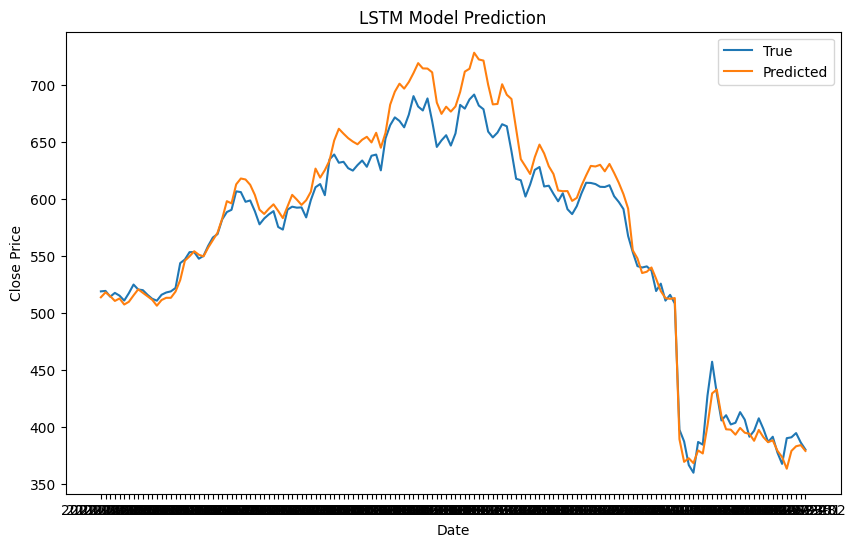

In [269]:
# Define the LSTM model
lstm = Sequential()
lstm.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm.add(Dropout(0.3))
lstm.add(LSTM(units=64, return_sequences=True))
lstm.add(Dropout(0.3))
lstm.add(LSTM(units=64))
lstm.add(Dropout(0.3))
lstm.add(Dense(units=1))

# Compile the model
lstm.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping callback
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# Fit the model
history = lstm.fit(X_train, Y_train, epochs=100, batch_size=64, validation_data=(X_test, Y_test), callbacks=[es])

# Evaluate the model
predicted_values = lstm.predict(X_test)
#predicted_values = scaler.inverse_transform(predicted_values)  # Inverse scaling to get actual values
predicted_values = scaler.inverse_transform(np.concatenate((X_test.squeeze(), predicted_values), axis=1))[:, -1]  # Inverse scaling


# Calculate metrics (e.g., Mean Absolute Percentage Error)
mse = mean_squared_error(Y_test, predicted_values)
mape = mean_absolute_percentage_error(Y_test, predicted_values)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data['Close'], label='True')
plt.plot(test_data.index, predicted_values, label='Predicted')
plt.title('LSTM Model Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [270]:
Y_pred = model.predict(X_test)
rmse = mean_squared_error(Y_test, Y_pred, squared=False)

def mean_absolute_percentage_error(Y_true, Y_pred):
    Y_true, Y_pred = np.array(Y_true), np.array(Y_pred)
    return np.mean(np.abs((Y_true - Y_pred) / Y_true))

mape = mean_absolute_percentage_error(Y_test, Y_pred)

print("RMSE", rmse)
print("MAPE", mape)

5/5 [==============================] - 0s 5ms/step
RMSE 0.03412011064065472
MAPE 0.44896662708705076


Test RMSE: 98.508
Test MAPE: 0.159


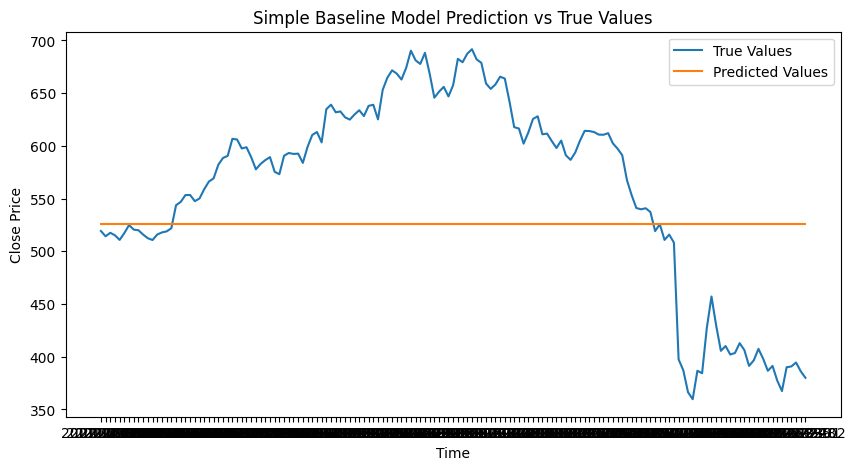

In [275]:
train_split = 0.8
split_idx = int(np.ceil(len(stock_data) * train_split))
train = stock_data[['Close']].iloc[:split_idx]
test = stock_data[['Close']].iloc[split_idx:]

test_pred = np.array([train.rolling(10).mean().iloc[-1]] * len(test)).reshape((-1, 1))

print('Test RMSE: %.3f' % mean_squared_error(test, test_pred, squared=False))
print('Test MAPE: %.3f' % mean_absolute_percentage_error(test, test_pred))

plt.figure(figsize=(10, 5))
plt.plot(test, label='True Values')
plt.plot(test_pred, label='Predicted Values')
plt.title('Simple Baseline Model Prediction vs True Values')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

Test RMSE: 99.984
Test MAPE: 0.161


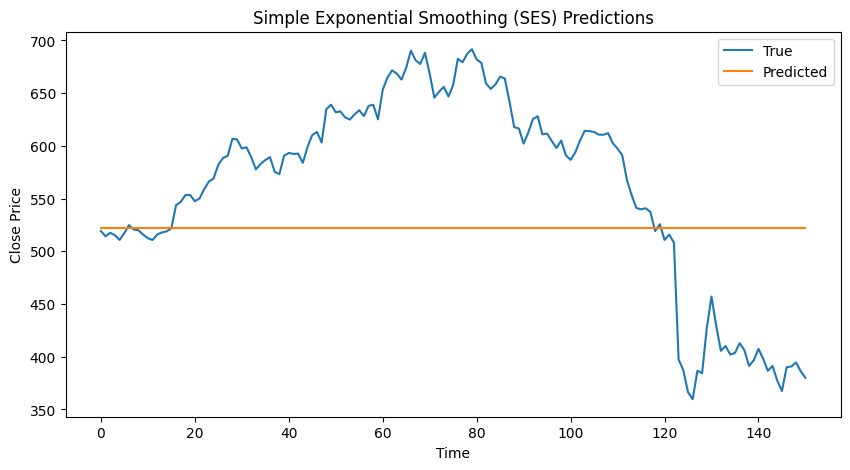

In [274]:
from statsmodels.tsa.api import SimpleExpSmoothing

X = stock_data[['Close']].values
train_split = 0.8
split_idx = int(np.ceil(len(X) * train_split))
train = X[:split_idx]
test = X[split_idx:]
test_concat = np.array([]).reshape((0, 1))

for i in range(len(test)):
    train_fit = np.concatenate((train, np.asarray(test_concat)))
    fit = SimpleExpSmoothing(np.asarray(train_fit)).fit(smoothing_level=0.2)
    test_pred = fit.forecast(1)
    test_concat = np.concatenate((np.asarray(test_concat), test_pred.reshape((-1, 1))))

print('Test RMSE: %.3f' % mean_squared_error(test, test_concat, squared=False))
print('Test MAPE: %.3f' % mean_absolute_percentage_error(test, test_concat))

plt.figure(figsize=(10, 5))
plt.plot(test, label='True')
plt.plot(test_concat, label='Predicted')
plt.title('Simple Exponential Smoothing (SES) Predictions')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()